# 🔮 Forecasting with OpenSTEF 4.0 Workflow Presets

This tutorial demonstrates how to use **OpenSTEF 4.0** to create energy load forecasts using the **Workflow Presets** pattern. You'll learn how to:

1. **Load real-world energy data** from the Liander 2024 benchmark dataset
2. **Configure a forecasting workflow** with weather features and prediction quantiles
3. **Train a model** and inspect its performance
4. **Generate probabilistic forecasts** with confidence intervals
5. **Visualize results** and explain feature importance

> **OpenSTEF** (Short-Term Energy Forecasting) is a modular library for creating accurate energy forecasts in the power grid domain.

In [11]:
# --- Setup: Logging and Display Configuration ---
# Configure logging to see training progress and plotly to render as PNG for VS Code compatibility
import logging
import pandas as pd
import plotly.io as pio

pd.options.plotting.backend = "plotly"
pio.renderers.default = "png"  # Use PNG for VS Code notebook compatibility

logging.basicConfig(level=logging.INFO, format="[%(asctime)s][%(levelname)s] %(message)s")
logger = logging.getLogger(__name__)
logging.getLogger("choreographer").setLevel(logging.ERROR)
logging.getLogger("kaleido").setLevel(logging.ERROR)
logging.getLogger("choreographer").disabled = True
logging.getLogger("kaleido").disabled = True

## 📦 Step 1: Download the Dataset

We'll use the **Liander 2024 Energy Forecasting Benchmark** dataset from HuggingFace Hub. This dataset contains:
- **Load measurements** — historical energy consumption from various installations (mv feeders, transformers, etc.)
- **Weather forecasts** — versioned weather predictions (temperature, radiation, wind, etc.)
- **EPEX prices** — day-ahead electricity market prices
- **Profiles** — typical daily/weekly load patterns

In [ ]:
# Download dataset from HuggingFace Hub
# The dataset is stored as parquet files for efficient loading
from huggingface_hub import hf_hub_download
from openstef_core.base_model import Path

repo_id = "OpenSTEF/liander2024-energy-forecasting-benchmark"  # Public benchmark dataset
local_dir = Path("./liander_dataset")
target = "mv_feeder/OS Gorredijk"  # Specific installation to focus on

# Download required files: load measurements, weather, prices, and profiles
files_to_download = [
    "load_measurements/mv_feeder/OS Gorredijk.parquet",  # Energy consumption data
    "weather_forecasts_versioned/mv_feeder/OS Gorredijk.parquet",  # Weather features
    "EPEX.parquet",  # Electricity prices (optional feature)
    "profiles.parquet"  # Standard load profiles (optional feature)
]

for filename in files_to_download:
    print(f"Downloading {filename}...")
    hf_hub_download(repo_id=repo_id, filename=filename, repo_type="dataset",
                    local_dir=local_dir, local_dir_use_symlinks=False)
    print(f"✓ {filename} downloaded")

print("\n✅ All files downloaded successfully!")

/Users/egor.dmitriev/projects/openstef/openstef4/.venv/lib/python3.13/site-packages/huggingface_hub/utils/_validators.py:202: UserWarning:

The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.

[2025-12-12 14:12:32,556][INFO] HTTP Request: HEAD https://huggingface.co/datasets/OpenSTEF/liander2024-energy-forecasting-benchmark/resolve/main/load_measurements/mv_feeder/OS%20Gorredijk.parquet "HTTP/1.1 302 Found"


✓ load_measurements/mv_feeder/OS Gorredijk.parquet downloaded


[2025-12-12 14:12:32,672][INFO] HTTP Request: HEAD https://huggingface.co/datasets/OpenSTEF/liander2024-energy-forecasting-benchmark/resolve/main/weather_forecasts_versioned/mv_feeder/OS%20Gorredijk.parquet "HTTP/1.1 302 Found"
[2025-12-12 14:12:32,814][INFO] HTTP Request: HEAD https://huggingface.co/datasets/OpenSTEF/liander2024-energy-forecasting-benchmark/resolve/main/EPEX.parquet "HTTP/1.1 302 Found"
[2025-12-12 14:12:32,815][WARNING] Warning: You are sending unauthenticated requests to the HF Hub. Please set a HF_TOKEN to enable higher rate limits and faster downloads.


✓ weather_forecasts_versioned/mv_feeder/OS Gorredijk.parquet downloaded
✓ EPEX.parquet downloaded


[2025-12-12 14:12:32,928][INFO] HTTP Request: HEAD https://huggingface.co/datasets/OpenSTEF/liander2024-energy-forecasting-benchmark/resolve/main/profiles.parquet "HTTP/1.1 302 Found"


✓ profiles.parquet downloaded

✅ All files downloaded successfully!


## 📊 Step 2: Load and Prepare the Data

OpenSTEF uses **VersionedTimeSeriesDataset** — a specialized data structure that handles:
- **Time versioning** — tracks when data became available (crucial for realistic backtesting)
- **Lazy composition** — efficiently combines datasets without O(n²) memory overhead
- **Temporal alignment** — ensures all features are properly aligned by timestamp

In [ ]:
# Load datasets using OpenSTEF's VersionedTimeSeriesDataset
# This class handles versioned data where each value has an "available_at" timestamp
from openstef_core.datasets import VersionedTimeSeriesDataset

# Load each data source from parquet files
load_dataset = VersionedTimeSeriesDataset.read_parquet(
    local_dir / "load_measurements/mv_feeder/OS Gorredijk.parquet"
)
weather_dataset = VersionedTimeSeriesDataset.read_parquet(
    local_dir / "weather_forecasts_versioned/mv_feeder/OS Gorredijk.parquet"
)
epex_dataset = VersionedTimeSeriesDataset.read_parquet(local_dir / "EPEX.parquet")
profiles_dataset = VersionedTimeSeriesDataset.read_parquet(local_dir / "profiles.parquet")

# Combine all datasets using left join (keep all load timestamps, match features where available)
# select_version() materializes the lazy dataset into a concrete TimeSeriesDataset
dataset = VersionedTimeSeriesDataset.concat(
    [load_dataset, weather_dataset, epex_dataset, profiles_dataset], 
    mode="left"  # Left join keeps all timestamps from the first dataset
).select_version()

# Preview the combined dataset
print(f"Dataset shape: {dataset.data.shape}")
print(f"Date range: {dataset.data.index.min()} to {dataset.data.index.max()}")
dataset.data.head()

[2025-12-12 14:12:32,950][WARNING] Parquet file does not contain 'sample_interval' attribute. Using default value of 15 minutes.


[2025-12-12 14:12:32,987][WARNING] Parquet file does not contain 'sample_interval' attribute. Using default value of 15 minutes.
[2025-12-12 14:12:33,038][WARNING] Parquet file does not contain 'sample_interval' attribute. Using default value of 15 minutes.
[2025-12-12 14:12:33,047][WARNING] Parquet file does not contain 'sample_interval' attribute. Using default value of 15 minutes.


Dataset shape: (35136, 28)
Date range: 2024-01-01 00:00:00+00:00 to 2024-12-31 23:45:00+00:00


,load,temperature_2m,relative_humidity_2m,surface_pressure,cloud_cover,wind_speed_10m,wind_speed_80m,wind_direction_10m,shortwave_radiation,direct_radiation,...,E1C_AMI_A,E2A_AZI_A,E2A_AMI_A,E2B_AZI_A,E2B_AMI_A,E3A_A,E3B_A,E3C_A,E3D_A,E4A_A
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-01-01 00:00:00+00:00,423333.333333,7.243500,85.025322,994.236450,100.0,28.185953,43.832863,204.928452,0.0,0.0,...,0.000064,0.000024,0.000034,0.000053,0.000064,0.000058,0.000058,0.000058,0.000058,0.000079
2024-01-01 00:15:00+00:00,436666.666667,7.281000,84.808533,994.186523,100.0,28.753380,44.976219,206.931015,0.0,0.0,...,0.000061,0.000024,0.000034,0.000052,0.000063,0.000058,0.000058,0.000058,0.000058,0.000079
2024-01-01 00:30:00+00:00,410000.000000,7.318501,84.591743,994.136597,100.0,29.320807,46.119572,208.933563,0.0,0.0,...,0.000060,0.000023,0.000033,0.000051,0.000063,0.000058,0.000058,0.000058,0.000058,0.000079
2024-01-01 00:45:00+00:00,403333.333333,7.356000,84.374954,994.086731,100.0,29.888233,47.262924,210.936127,0.0,0.0,...,0.000057,0.000023,0.000032,0.000051,0.000061,0.000059,0.000059,0.000059,0.000059,0.000079
2024-01-01 01:00:00+00:00,420000.000000,7.393500,84.158165,994.036804,100.0,30.455660,48.406281,212.938690,0.0,0.0,...,0.000055,0.000024,0.000032,0.000052,0.000060,0.000057,0.000057,0.000057,0.000057,0.000079


## ✂️ Step 3: Split Data into Training and Forecast Periods

We'll use:
- **90 days** of historical data for training
- **14 days** as the forecast period (where we'll generate predictions)

In [14]:
# Define training and forecast time periods
from datetime import datetime, timedelta

# Training period: 90 days of historical data
train_start = datetime.fromisoformat("2024-03-01T00:00:00Z")
train_end = train_start + timedelta(days=90)

# Forecast period: 14 days after training (this is where we'll predict)
forecast_start = train_end
forecast_end = forecast_start + timedelta(days=14)

# Split the dataset using time-based filtering
train_dataset = dataset.filter_by_range(start=train_start, end=train_end)
forecast_dataset = dataset.filter_by_range(start=forecast_start, end=forecast_end)

print(f"📈 Training period: {train_start.date()} to {train_end.date()} ({len(train_dataset.data)} samples)")
print(f"🔮 Forecast period: {forecast_start.date()} to {forecast_end.date()} ({len(forecast_dataset.data)} samples)")

📈 Training period: 2024-03-01 to 2024-05-30 (8640 samples)
🔮 Forecast period: 2024-05-30 to 2024-06-13 (1344 samples)


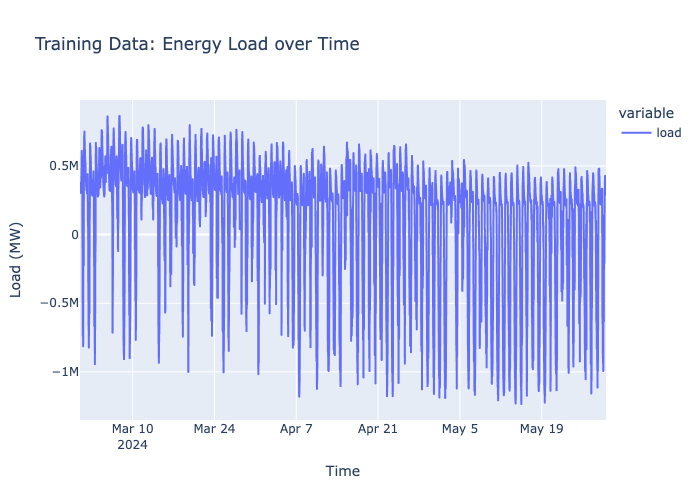

In [15]:
# Visualize the training data
# The plot shows the 'load' column (energy consumption in MW) over time
fig = train_dataset.data[["load"]].plot(title="Training Data: Energy Load over Time")
fig.update_layout(yaxis_title="Load (MW)", xaxis_title="Time")
fig.show()

## ⚙️ Step 4: Configure the Forecasting Workflow

OpenSTEF uses a **ForecastingWorkflowConfig** to define all aspects of the forecasting pipeline:
- **Model type** — `gblinear` (gradient boosted linear model) or `xgboost`
- **Forecast horizons** — how far ahead to predict (e.g., 36 hours)
- **Quantiles** — prediction intervals for probabilistic forecasts
- **Feature columns** — which weather variables to use

The **GBLinear** model is particularly good for energy forecasting because:
1. It can extrapolate beyond training data (important for rare events)
2. It provides interpretable feature importance
3. It's fast to train and predict

In [16]:
# Import workflow components
from openstef_core.types import LeadTime, Q  # LeadTime: forecast horizon, Q: quantile
from openstef_models.presets import ForecastingWorkflowConfig, create_forecasting_workflow
from openstef_models.presets.forecasting_workflow import GBLinearForecaster

# Configure the forecasting workflow
workflow = create_forecasting_workflow(
    config=ForecastingWorkflowConfig(
        # Model identification
        model_id="gblinear_demo_v1",
        model="gblinear",  # Use gradient boosted linear model
        
        # Forecast settings
        horizons=[LeadTime.from_string("PT36H")],  # Predict up to 36 hours ahead
        quantiles=[Q(0.5), Q(0.1), Q(0.9)],  # Median + 80% prediction interval
        
        # Target column (what we're predicting)
        target_column="load",
        
        # Weather feature columns (from the dataset)
        temperature_column="temperature_2m",
        relative_humidity_column="relative_humidity_2m",
        wind_speed_column="wind_speed_10m",
        radiation_column="shortwave_radiation",  # Solar radiation
        pressure_column="surface_pressure",
        
        # Training settings
        verbosity=1,  # Show progress during training
        mlflow_storage=None,  # Disable MLflow tracking for this demo
        
        # Model-specific hyperparameters
        gblinear_hyperparams=GBLinearForecaster.HyperParams(
            n_steps=50  # Number of boosting iterations
        )
    )
)

print("✅ Workflow configured successfully!")

✅ Workflow configured successfully!


## 🏋️ Step 5: Train the Model

The workflow's `fit()` method handles the entire training pipeline:
1. **Preprocessing** — feature engineering, data validation, scaling
2. **Training** — fit the model on historical data
3. **Evaluation** — compute metrics on training data

In [17]:
# Train the model on historical data
logger.info("🏋️ Starting model training...")

result = workflow.fit(train_dataset)

# Display training metrics
if result is not None:
    logger.info("✅ Training complete!")
    print("\n📊 Training Evaluation Metrics:")
    print(result.metrics_full.to_dataframe())
    
    if result.metrics_test is not None:
        print("\n📊 Test Set Metrics (held-out validation):")
        print(result.metrics_test.to_dataframe())

[2025-12-12 14:12:35,855][INFO] 🏋️ Starting model training...
[2025-12-12 14:12:35,992][WARNING] No aggregation functions specified for RollingAggregatesAdder. Returning original data.
[2025-12-12 14:12:36,109][WARNING] No aggregation functions specified for RollingAggregatesAdder. Returning original data.


[0]	validation_0-mean_pinball_loss:0.34619	validation_1-mean_pinball_loss:0.36512
[1]	validation_0-mean_pinball_loss:0.28327	validation_1-mean_pinball_loss:0.28960
[2]	validation_0-mean_pinball_loss:0.23968	validation_1-mean_pinball_loss:0.24857
[3]	validation_0-mean_pinball_loss:0.20084	validation_1-mean_pinball_loss:0.21070
[4]	validation_0-mean_pinball_loss:0.16668	validation_1-mean_pinball_loss:0.17744
[5]	validation_0-mean_pinball_loss:0.14015	validation_1-mean_pinball_loss:0.15102
[6]	validation_0-mean_pinball_loss:0.12257	validation_1-mean_pinball_loss:0.13536
[7]	validation_0-mean_pinball_loss:0.11089	validation_1-mean_pinball_loss:0.12362
[8]	validation_0-mean_pinball_loss:0.10177	validation_1-mean_pinball_loss:0.11396
[9]	validation_0-mean_pinball_loss:0.09542	validation_1-mean_pinball_loss:0.10819
[10]	validation_0-mean_pinball_loss:0.09122	validation_1-mean_pinball_loss:0.10361
[11]	validation_0-mean_pinball_loss:0.08817	validation_1-mean_pinball_loss:0.10134


/Users/egor.dmitriev/projects/openstef/openstef4/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/Users/egor.dmitriev/projects/openstef/openstef4/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names



[12]	validation_0-mean_pinball_loss:0.08606	validation_1-mean_pinball_loss:0.09880
[13]	validation_0-mean_pinball_loss:0.08434	validation_1-mean_pinball_loss:0.09764
[14]	validation_0-mean_pinball_loss:0.08324	validation_1-mean_pinball_loss:0.09593
[15]	validation_0-mean_pinball_loss:0.08256	validation_1-mean_pinball_loss:0.09539
[16]	validation_0-mean_pinball_loss:0.08257	validation_1-mean_pinball_loss:0.09481
[17]	validation_0-mean_pinball_loss:0.08251	validation_1-mean_pinball_loss:0.09515
[18]	validation_0-mean_pinball_loss:0.08331	validation_1-mean_pinball_loss:0.09463
[19]	validation_0-mean_pinball_loss:0.08284	validation_1-mean_pinball_loss:0.09461
[20]	validation_0-mean_pinball_loss:0.08272	validation_1-mean_pinball_loss:0.09353
[21]	validation_0-mean_pinball_loss:0.08310	validation_1-mean_pinball_loss:0.09463
[22]	validation_0-mean_pinball_loss:0.08209	validation_1-mean_pinball_loss:0.09301
[23]	validation_0-mean_pinball_loss:0.08167	validation_1-mean_pinball_loss:0.09290
[24]

[2025-12-12 14:12:36,827][WARNING] No aggregation functions specified for RollingAggregatesAdder. Returning original data.
[2025-12-12 14:12:37,064][INFO] ✅ Training complete!



📊 Training Evaluation Metrics:
   quantile        R2  observed_probability
0       0.5  0.835640              0.588889
1       0.1  0.546782              0.092940
2       0.9  0.673923              0.894097


## 🔮 Step 6: Generate Forecasts

Now we use the trained model to predict energy load for the next 14 days. The output is a **ForecastDataset** containing:
- **Median prediction** (`quantile_P50`)
- **Lower bound** (`quantile_P10`) — 10th percentile
- **Upper bound** (`quantile_P90`) — 90th percentile

In [18]:
# Generate probabilistic forecasts for the forecast period
from openstef_core.datasets import ForecastDataset

logger.info("🔮 Generating forecasts...")
forecast: ForecastDataset = workflow.predict(forecast_dataset)

# Display forecast summary
print(f"\n📈 Forecast generated for {len(forecast.data)} timestamps")
print(f"📊 Quantiles: {forecast.quantiles}")
print("\n🔍 Last 5 forecast values:")
print(forecast.data.tail())

[2025-12-12 14:12:37,071][INFO] 🔮 Generating forecasts...
[2025-12-12 14:12:37,120][WARNING] No aggregation functions specified for RollingAggregatesAdder. Returning original data.



📈 Forecast generated for 1344 timestamps
📊 Quantiles: [0.5, 0.1, 0.9]

🔍 Last 5 forecast values:
                           quantile_P50  quantile_P10  quantile_P90  \
timestamp                                                             
2024-06-12 22:45:00+00:00  438055.28125  346233.06250  460536.84375   
2024-06-12 23:00:00+00:00  417909.34375  335798.56250  438184.90625   
2024-06-12 23:15:00+00:00  410978.18750  330271.25000  429153.15625   
2024-06-12 23:30:00+00:00  398514.87500  318843.21875  413887.43750   
2024-06-12 23:45:00+00:00  381927.81250  306417.43750  397558.40625   

                                    load         stdev  
timestamp                                               
2024-06-12 22:45:00+00:00  326666.666667  36988.759513  
2024-06-12 23:00:00+00:00  326666.666667  35235.209770  
2024-06-12 23:15:00+00:00  320000.000000  35235.209770  
2024-06-12 23:30:00+00:00  310000.000000  35235.209770  
2024-06-12 23:45:00+00:00  296666.666667  35235.209770  


## 📈 Step 7: Visualize Forecast Results

OpenSTEF-BEAM provides **ForecastTimeSeriesPlotter** for beautiful interactive visualizations:
- Actual measurements shown as a line
- Forecast median shown as another line
- Prediction intervals shown as shaded areas

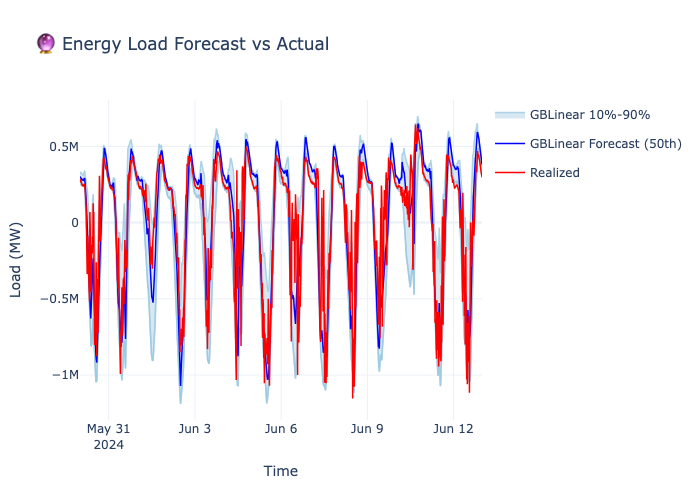

In [19]:
# Create an interactive forecast visualization
from openstef_beam.analysis.plots import ForecastTimeSeriesPlotter

fig = (
    ForecastTimeSeriesPlotter()
    # Add actual measurements (ground truth)
    .add_measurements(measurements=forecast_dataset.data["load"])
    # Add model predictions with confidence bands
    .add_model(
        model_name="GBLinear",
        forecast=forecast.median_series,  # P50 prediction
        quantiles=forecast.quantiles_data  # P10-P90 confidence band
    )
    .plot()
)

# Update layout for better presentation
fig.update_layout(
    title="🔮 Energy Load Forecast vs Actual",
    yaxis_title="Load (MW)",
    xaxis_title="Time",
    height=500
)
fig.show()

## 🔍 Step 8: Explain Feature Importance

Understanding **why** the model makes certain predictions is crucial for trust and debugging. GBLinear models provide clear feature importance rankings.

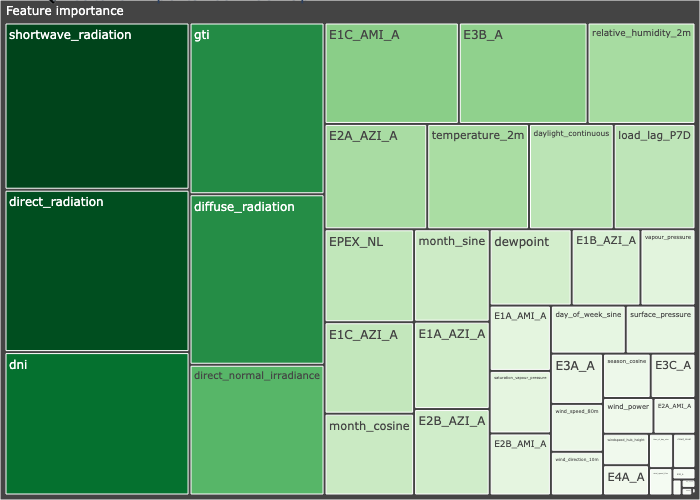

In [20]:
# Visualize feature importance using the ExplainableForecaster interface
from typing import cast
from openstef_models.explainability import ExplainableForecaster

# The GBLinear model implements ExplainableForecaster, providing feature importance
explainable_model = cast(ExplainableForecaster, workflow.model.forecaster)

# Create an interactive treemap of feature importances
# Larger boxes = more important features
fig = explainable_model.plot_feature_importances()
fig.update_layout(title="🔍 Feature Importance Treemap")
fig.show()

---

## 🎯 Summary

In this tutorial, you learned how to:

1. ✅ **Load energy data** from the Liander 2024 benchmark dataset
2. ✅ **Configure a workflow** with `ForecastingWorkflowConfig`
3. ✅ **Train a GBLinear model** for probabilistic forecasting
4. ✅ **Generate forecasts** with confidence intervals
5. ✅ **Visualize results** and feature importance

### 🚀 Next Steps

- Try different models: `"xgboost"` for more complex patterns
- Experiment with more quantiles for narrower prediction intervals
- Use the **backtesting notebook** to evaluate model performance systematically
- Explore MLflow integration for experiment tracking